# ML with Large Datasets
----
## Dataset Description
In order to explore these Spark API, we use the [following dataset](). The data is from a population and housing census of some country ```X```  not identified for privacy reasons although this data is a very small subset of the actual data. 
Each row in the data represent a single individual in the population. 
 A summary of column description is provided below:
- **Geographic identifiers:** PROVINCE, REGION, DISTRICT, COMMUNE,MILIEU ,
       IDMEN, IDINDIV. This type of data has a somewhat hierarchical structure. We have a household (think of it as family), IDMEN-household ID. Within each household, we have individuals, IDINDIV - individual
       > 
- **MILIEU:** A classification of whether this person lived in urban or rural area. ```2-Rural, 1-Urban```
- **Sex**. ```P05```==>[1	- Male 2	- Female]
- **P19 Languages spoken**. What languages the person can speak.This variable is split into 4 variables as follows: ```P19MG, P19FR, P19AN, P19AU``` for local language, English, French and any other language.
- **P20, Literacy**. Whether the person can read and write any of the 3 languages given. Note that there three variables each representing each language. A local language, French and English. For each language, the value 1 means they can read and write in the language while 2 means they cannot.The variables are ```P20MG (local language), P20FR (French), P20AN (English), P20AU (other)```. 
- **P03:** whether the person is the head of the household, wife. child etc==>[0- Chef de Ménage (CM) 1- Conjoint(e) (CJ) 2-	Fils/Fille3-	Père/Mère 4-	Beau-Père/Belle-Mère 5-	Beau-Fils/Belle-Fille 6-	Petit fils/Petite-fille
 Autre Proche du CM 8- Autre proche du CJ 9 -Sans lien de parenté]

- **Age:**. Person's date of birth is given by column ```P07M``` (month of birth), ```P07A``` (year of birth) and ```P08``` (age)
- **Marital status:** ```P28``` (whether the person is married or not)==>[1-	Célibataire, 2-	Marié(e), 3-	Divorcé(e)/Séparé(e), 4-	Veuf(ve)]. This question is asked to residents who are 12 years or older. 
- **Age at first marriage**. ```P29``` (age at marriage).The question was like this: How old was <NAME> when he/she got married for the first time?
- **School attendance:** ```P21``` ==>[0 N'a Jamais fréquenté 1-A	fréquenté 2- Fréquente actuellement]
- **Highest school level attended:**```P22N```. This variable represents highest level of school attended. The question was asked like this: What is the highest level of education that (name) achieved during his studies?
 > 1. Preschool; 2. Primary-school; 3. Secondary; 4. Technical college; 5. University 
 - **Number of years of school completed at a particular level:** ```P22C``` Years completed at that level. A value of 0 means the person didnt complete the first year of education at that level. 
 > Preschool(0-2); Primary-school(0-5);Secondary(0-7); Technical college (0-7); University (0-7)
 
- **Whether the person worked or not:** ```P23```==> [1-	0ccupé 2-	Chômeur 3-	En quête du 1er emploi 4-	Ménagère 5-	Elève/Etudiant 6-	Retraité 7- lncapacité à travailler 8- Autre]

## The Task
The Ministry of Health in the country has expressed concern about the prevalence of early marriages among young individuals (both men and women). They have tasked you with investigating the factors contributing to early marriages. For the purpose of this analysis, individuals who get married at the age of 18 or younger are classified as having married early or belonging to the early marriage category. Beyond conducting exploratory analysis, the Ministry has requested that you develop a model to predict whether a person is likely to marry young, based on factors such as place of residence, household size, parents' education levels, and other relevant variables. In summary, these are the project goals.
1. Perfom explotaory analysis to understand early marriages 
2. Build a Machine Learning model which can predict whether a person will get married early or not.
3. Report on the model performance and efficacy

## Task 1

## Strategy for Efficiently Loading Data:

- In order to deal with the large dataset we shaal Use Spark for Loading Large Datasets.
 - Spark is well-suited for handling large datasets as it operates in a distributed manner and does not require loading the entire dataset into memory at once.  By using PySpark, we can efficiently read the large CSV file and perform initial data filtering and transformations.

- We shall Select Only the Relevant Columns.
 - Based on the task description and dataset requirements, we will only load the columns necessary for the analysis. By doing this, we reduce the memory overhead and make the loading process faster. We'll use the select method in Spark to load only the relevant columns, as defined by the task.

- Filter and Clean the Data Using Spark.
 - Before proceeding with analysis, we will filter out rows with missing or irrelevant values (e.g., rows where Age or Age_Fst_Mar are missing) to ensure data quality. This will be done using Spark's filtering capabilities, reducing the size of the dataset before exporting it.

- Save to a Smaller CSV File.
  - After filtering and subsetting the data, we can save the processed data to a smaller CSV file. This file will contain only the rows and columns we need for further analysis. This will allow us to work with a smaller dataset while keeping the memory usage manageable.

- Switch to Pandas for Further Processing:
  - Once we have a smaller CSV file with the relevant data, we can load it into Pandas for more detailed analysis and processing, taking advantage of Pandas' extensive data manipulation capabilities.

## Python setup

In [47]:
## Python setup
from datetime import datetime
from IPython.display import Image
import pandas as pd
pd.options.display.float_format = '{:.2f}'.format
import numpy as np
from pathlib import Path
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf

from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorAssembler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF, GradientBoostingClassifier as GBM, ExtraTreesClassifier as ETC, AdaBoostClassifier as Ada
from sklearn.metrics import accuracy_score, classification_report, accuracy_score
from tabulate import tabulate

# Inputs Paths, Global Variables and Parameters
Lets provide paths to input files we will use. 
Its a good practice to create these as global variables. Also, use Python module ```Path``` from pathlib to manage file paths. 

In [51]:
# path to hh_data.txt
HH_DATA = "/home/evans/Downloads/population-project-dataset/ResidentIBEIPM.csv"

# Selecting the columns to keep
COLS_TO_KEEP = [
    "PROVINCE",           # Geographic identifier: Province
    "REGION",             # Geographic identifier: Region
    "DISTRICT",           # Geographic identifier: District
    "COMMUNES",           # Geographic identifier: Commune
    "MILIEU",             # Urban vs. Rural classification (1=Urban, 2=Rural)
    "IDMEN",              # Household ID
    "IDINDIV",            # Individual ID within a household
    "P05",                # Sex (1=Male, 2=Female)
    "P19MG",              # Speaks local language (1=Yes, 2=No)
    "P19FR",              # Speaks French (1=Yes, 2=No)
    "P19AN",              # Speaks English (1=Yes, 2=No)
    "P19AU",              # Speaks other language (1=Yes, 2=No)
    "P20MG",              # Literacy in local language (1=Can read/write, 2=Cannot)
    "P20FR",              # Literacy in French (1=Can read/write, 2=Cannot)
    "P20AN",              # Literacy in English (1=Can read/write, 2=Cannot)
    "P03",                # Relationship to household head 
                          # as (0=Head, 1=Spouse, 2=Child, 3=Parent, etc.)
    "P08",                # Age
    "P28",                # Marital status (1=Single, 2=Married, 3=Divorced, 4=Widowed)
    "P29",                # Age at first marriage
    "P21",                # School attendance (0=Never attended, 1=Attended, 2=Currently attending)
    "P22N",               # Highest school level attended
                          # (1=Preschool, 2=Primary, 3=Secondary, 4=Technical, 5=University)
    "P22C",               # Years of schooling completed
                          # (varies based on school level: Preschool(0-2), Primary(0-5), etc.)
    "P23"                 # Employment status
                          # (1=Employed, 2=Unemployed, 3=Seeking first job, etc.)
]


# Regular household size threshold
# use quintiles to determine the threshold
HH_SIZE_THRESHOLD = 0.99

# CHILFREN AGE THRESHOLD
CHILDREN_AGE_THRESHOLD = 15
ELDERY_AGE_THRESHOLD = 65
EARLY_MARRIAGE_AGE_THRESHOLD = 18
    

In [49]:
spark = SparkSession.builder\
                .appName("LargeDatasetProcessing")\
                .master(f"local[10]")\
                .config("spark.driver.memory", "56g")\
                .config("spark.executor.memory", "56g")\
                .config("spark.memory.offHeap.enabled", "true")\
                .config("spark.sql.shuffle.partitions", "40")\
                .config("spark.memory.offHeap.size", "4g")\
                .config("spark.driver.bindAddress", "127.0.0.1") \
                .getOrCreate()

# Preprocess the Data

The objective here is to load the dataset, retain only the necessary columns to reduce its size, and enable faster processing. During preprocessing, we aim to clean up the columns and convert numeric columns into proper numeric data types.

## Load the Data

I use Spark for loading the data because it is faster than pandas. Alternatively, students can use the pandas "chunk" method to load data in manageable chunks. Another approach is to first load a small sample of the dataset, identify and document the required columns, and then load only those columns from the full dataset.

## Subset the Columns

Whether or not all columns were initially loaded, this step involves selecting only the required columns for further processing.

## Preprocess and Clean Data

For columns such as `age`, ensure they are in numeric format. Rows containing invalid or erroneous data can be removed as part of the cleaning process.


In [5]:
sdf = spark.read.csv(HH_DATA, header=True, sep=",", inferSchema=True)


## Subset the Data
Keep only the columns we need and save a smaller dataset.

In [52]:
sdf2 = sdf.select(COLS_TO_KEEP)


In [53]:
# ====================================
# RENAME COLUMNS
# ====================================
# Rename the columns to more meaningful names for easy understanding and ide


# Mapping of old column names to shorter, descriptive names
rename_mapping = {
    "PROVINCE": "Prov",                 # Province
    "REGION": "Reg",                   # Region
    "DISTRICT": "Dist",                # District
    "COMMUNES": "Comm",                # Commune
    "MILIEU": "Loc",                   # Location (1=Urban, 2=Rural)
    "IDMEN": "HH_ID",                  # Household ID
    "IDINDIV": "Indiv_ID",             # Individual ID
    "P05": "Gender",                      # Gender (1=Male, 2=Female)
    "P19MG": "Lang_Loc",               # Speaks local language
    "P19FR": "Lang_Fr",                # Speaks French
    "P19AN": "Lang_En",                # Speaks English
    "P19AU": "Lang_Oth",               # Speaks other language
    "P20MG": "Lit_Loc",                # Literate in local language
    "P20FR": "Lit_Fr",                 # Literate in French
    "P20AN": "Lit_En",                 # Literate in English
    "P03": "Rel_Head",                 # Relationship to household head
    "P08": "Age",                      # Age
    "P28": "M_Status",                 # Marital status
    "P29": "Age_Fst_Mar",              # Age at first marriage
    "P21": "Sch_Att",                  # School attendance
    "P22N": "Sch_Lvl",                 # Highest school level attended
    "P22C": "Sch_Yrs",                 # Years of schooling completed
    "P23": "Emp_Status"                # Employment status
}

# Apply renaming
for old_name, new_name in rename_mapping.items():
    sdf2 = sdf2.withColumnRenamed(old_name, new_name)

# Display the schema to confirm renaming
sdf2.show()


+----+---+----+-----+---+--------------------+--------------------+------+--------+-------+-------+--------+-------+------+------+--------+---+--------+-----------+-------+-------+-------+----------+
|Prov|Reg|Dist| Comm|Loc|               HH_ID|            Indiv_ID|Gender|Lang_Loc|Lang_Fr|Lang_En|Lang_Oth|Lit_Loc|Lit_Fr|Lit_En|Rel_Head|Age|M_Status|Age_Fst_Mar|Sch_Att|Sch_Lvl|Sch_Yrs|Emp_Status|
+----+---+----+-----+---+--------------------+--------------------+------+--------+-------+-------+--------+-------+------+------+--------+---+--------+-----------+-------+-------+-------+----------+
|   1| 11| 111|11101|  1|11101101010011066...|11101101010010166...|     1|       1|      1|      2|       2|      1|     1|     2|       0| 63|       2|         24|      1|      3|      7|         6|
|   1| 11| 111|11101|  1|11101101010011066...|11101101010010166...|     2|       1|      1|      2|       2|      1|     1|     2|       1| 67|       2|         28|      1|      3|      7|         6|


## Data Preprocessing
- Rename columns for easy identification
- Perform data type conversion if necessary


### Type conversion and partial cleaning

In [54]:

from pyspark.sql.functions import col

# Iterate through all columns and cast them to integer
for col_name in sdf2.columns:
    sdf2 = sdf2.withColumn(col_name, col(col_name).cast("int"))


# partial cleaning to reduce storage consumption

# Droping rows where Age < 12 or Age > 100
sdf2 = sdf2.filter((col("Age") >= 12) & (col("Age") <= 100))

# Droping rows with missing values in critical columns
critical_columns = [ "Age", "M_Status", "Age_Fst_Mar"]
sdf2= sdf2.na.drop(subset=critical_columns)

# Repartition the DataFrame to 10 partitions
out_csv = "/home/evans/Downloads/PROJ/proj-dataset-small"

sdf2.repartition(10).coalesce(1).write.csv(out_csv, header=True, sep=",", mode="overwrite")
# Verifying schema changes
sdf2.printSchema()


root
 |-- Prov: integer (nullable = true)
 |-- Reg: integer (nullable = true)
 |-- Dist: integer (nullable = true)
 |-- Comm: integer (nullable = true)
 |-- Loc: integer (nullable = true)
 |-- HH_ID: integer (nullable = true)
 |-- Indiv_ID: integer (nullable = true)
 |-- Gender: integer (nullable = true)
 |-- Lang_Loc: integer (nullable = true)
 |-- Lang_Fr: integer (nullable = true)
 |-- Lang_En: integer (nullable = true)
 |-- Lang_Oth: integer (nullable = true)
 |-- Lit_Loc: integer (nullable = true)
 |-- Lit_Fr: integer (nullable = true)
 |-- Lit_En: integer (nullable = true)
 |-- Rel_Head: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- M_Status: integer (nullable = true)
 |-- Age_Fst_Mar: integer (nullable = true)
 |-- Sch_Att: integer (nullable = true)
 |-- Sch_Lvl: integer (nullable = true)
 |-- Sch_Yrs: integer (nullable = true)
 |-- Emp_Status: integer (nullable = true)



## Task-2-Data preprocessing


In [55]:
# ==========================================================
# Load the smaller CSV file just created as pandas DataFrame
# ==========================================================
df = pd.read_csv("/home/evans/Downloads/PROJ/proj-dataset-small/part-00000-24b097f6-bf0e-43ba-9d5c-3ba0352de8c1-c000.csv")
df.head()

,Prov,Reg,Dist,Comm,Loc,HH_ID,Indiv_ID,Gender,Lang_Loc,Lang_Fr,...,Lit_Fr,Lit_En,Rel_Head,Age,M_Status,Age_Fst_Mar,Sch_Att,Sch_Lvl,Sch_Yrs,Emp_Status
0,1,11,111,11101,1,-1806170558,1421458314,2,1.00,2.00,...,2.00,2.00,1,52,2,25,1,4.00,2.00,4
1,1,11,111,11101,1,-711109149,1514729139,2,1.00,2.00,...,2.00,2.00,7,52,3,18,1,2.00,5.00,8
2,1,11,111,11101,1,-1902677488,1149979521,1,1.00,1.00,...,1.00,2.00,0,68,4,24,1,4.00,1.00,1
3,1,11,111,11101,1,-1248039928,-1025741214,2,1.00,2.00,...,2.00,2.00,7,49,3,23,1,3.00,4.00,1
4,1,11,111,11101,1,-614584913,694250845,1,1.00,2.00,...,1.00,2.00,0,43,2,20,1,2.00,5.00,1


In [56]:
# Displaying basic information about the DataFrame
print("\nDataFrame Info:")
print(df.info())

# Check for missing values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10341348 entries, 0 to 10341347
Data columns (total 23 columns):
 #   Column       Dtype  
---  ------       -----  
 0   Prov         int64  
 1   Reg          int64  
 2   Dist         int64  
 3   Comm         int64  
 4   Loc          int64  
 5   HH_ID        int64  
 6   Indiv_ID     int64  
 7   Gender       int64  
 8   Lang_Loc     float64
 9   Lang_Fr      float64
 10  Lang_En      float64
 11  Lang_Oth     float64
 12  Lit_Loc      float64
 13  Lit_Fr       float64
 14  Lit_En       float64
 15  Rel_Head     int64  
 16  Age          int64  
 17  M_Status     int64  
 18  Age_Fst_Mar  int64  
 19  Sch_Att      int64  
 20  Sch_Lvl      float64
 21  Sch_Yrs      float64
 22  Emp_Status   int64  
dtypes: float64(9), int64(14)
memory usage: 1.8 GB
None

Missing Values in Each Column:
Prov                 0
Reg                  0
Dist                 0
Comm                 0
Loc                  0
HH_ID          

### Add New Variables We Need

In some cases, key information we need to explore may not be readily available in the dataset. For example, to analyze households, we might need to create a new column to represent household size.

#### Household Size
Household size refers to the number of people in a household. The dataset provides a household identifier (`hh_id`) and an individual identifier (`indiv_id`). Using these, we can generate a new column called `household_size`.

#### Feature Engineering: Creating Additional Variables
Feature engineering is the process of transforming raw data into meaningful features that improve the performance of machine learning models. This involves selecting, creating, modifying, or aggregating data attributes to make them more informative and relevant to the task at hand. Feature engineering is inherently a creative task—there are no strict rules. As a data scientist or machine learning practitioner, it's up to you to explore the data, consult domain experts, and study relevant literature to design and test new features.

For this analysis, we can consider creating the following features, which may influence the age at first marriage:

- **Number of dependent children in the household**: Defined as the number of individuals aged 15 and younger.
- **Number of dependent adults in the household**: Defined as the number of individuals aged 65 and older.

#### Household Level Variables 
Note that we have two levels of analysis units here: the individual and the household. As such, variables such as household size, number of children, number of the eldery are all household level variables. Since the head of the family or head of the household has more power in determing what happens in the house, we can also add household head variables. Concretely, for each household, we can have variables named like this: hoh_age, hoh_educ, hoh_literacy etc.

In [57]:
import pandas as pd

def gen_var_hh_size(df, hh_id_col='HH_ID', age_col='Age', indiv_id_col='Indiv_ID'):
    """
    Generates household-level variables, including household size,
    number of children, and number of elderly.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing individual-level data.
    hh_id_col : str, optional
        Column name for household ID, by default 'HH_ID'.
    age_col : str, optional
        Column name for age, by default 'Age'.
    indiv_id_col : str, optional
        Column name for individual ID, by default 'Indiv_ID'.

    Returns
    -------
    pd.DataFrame
        DataFrame with household-level variables merged back into the original DataFrame.
    """
    # ======================================================
    # GENERATE HH SIZE
    # ======================================================
    # Count the number of individuals in each household
    hh_size = df.groupby(hh_id_col)[indiv_id_col].count().reset_index()
    hh_size.columns = [hh_id_col, 'hh_size']
    
    # Add index for easier merging later
    df = df.reset_index(drop=True)

    # ======================================================
    # GENERATE NUMBER OF CHILDREN AND ELDERLY
    # ======================================================
    # Number of children (age <= 15)
    children = df[df[age_col] <= 15].groupby(hh_id_col)[indiv_id_col].count().reset_index()
    children.columns = [hh_id_col, 'num_children']

    # Number of elderly (age >= 65)
    elderly = df[df[age_col] >= 65].groupby(hh_id_col)[indiv_id_col].count().reset_index()
    elderly.columns = [hh_id_col, 'num_elderly']

    # ======================================================
    # MERGE THE DATAFRAMES
    # ======================================================
    # Merge household size, number of children, and number of elderly
    hh_vars = hh_size.merge(children, on=hh_id_col, how='left') \
                     .merge(elderly, on=hh_id_col, how='left')

    # ======================================================
    # FILL NAs WITH 0
    # ======================================================
    # Replace NA values with 0 for households with no children or elderly
    hh_vars.fillna({'num_children': 0, 'num_elderly': 0}, inplace=True)

    # ======================================================
    # CHECK THAT WE HAVE ALL HH_ID
    # ======================================================
    # Ensure all households in the original dataset are present in the new DataFrame
    assert df[hh_id_col].nunique() == hh_vars[hh_id_col].nunique(), \
        "Mismatch in household IDs between original and aggregated data."
    return hh_vars

In [58]:
# ====================================
# ADD HOUSEHOLD LEVEL VARIABLES
# ====================================
# Generate household-level variables
df_hh = gen_var_hh_size(df, hh_id_col='HH_ID', age_col='Age', indiv_id_col='Indiv_ID')

# Merge household-level variables back to the main DataFrame
df = df.merge(df_hh, on='HH_ID', how='left')

# Verify the merge
print("Sample of DataFrame with Household-Level Variables:")
print(df.head())

# Check for missing values in the merged columns
print("\nMissing Values After Merge:")
print(df[['hh_size', 'num_children', 'num_elderly']].isnull().sum())


Sample of DataFrame with Household-Level Variables:
   Prov  Reg  Dist   Comm  Loc       HH_ID    Indiv_ID  Gender  Lang_Loc  \
0     1   11   111  11101    1 -1806170558  1421458314       2      1.00   
1     1   11   111  11101    1  -711109149  1514729139       2      1.00   
2     1   11   111  11101    1 -1902677488  1149979521       1      1.00   
3     1   11   111  11101    1 -1248039928 -1025741214       2      1.00   
4     1   11   111  11101    1  -614584913   694250845       1      1.00   

   Lang_Fr  ...  Age  M_Status  Age_Fst_Mar  Sch_Att  Sch_Lvl  Sch_Yrs  \
0     2.00  ...   52         2           25        1     4.00     2.00   
1     2.00  ...   52         3           18        1     2.00     5.00   
2     1.00  ...   68         4           24        1     4.00     1.00   
3     2.00  ...   49         3           23        1     3.00     4.00   
4     2.00  ...   43         2           20        1     2.00     5.00   

   Emp_Status  hh_size  num_children  num_elde

# Explolatory Data Analysis (EDA)
Before any ML task, its important to understand the data. 
This is done by exploring the data to understand the data types, missing values, and the distribution of the data. This is important as it helps in understanding the data and the features that can be used in the ML model.

## Histogram of age at first marriage


Number of rows after dropping missing 'Age_Fst_Mar': 10341300


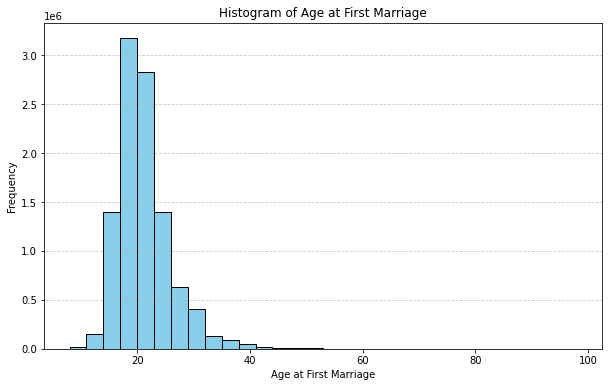

In [59]:
# Droping all rows where 'Age_Fst_Mar' is missing
df = df.dropna(subset=['Age_Fst_Mar'])
df = df[df['hh_size'] <= 20]


# Verify the number of remaining rows
print(f"Number of rows after dropping missing 'Age_Fst_Mar': {df.shape[0]}")
import matplotlib.pyplot as plt

# Plot histogram for 'Age_Fst_Mar'
plt.figure(figsize=(10, 6))
plt.hist(df['Age_Fst_Mar'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Age at First Marriage')
plt.xlabel('Age at First Marriage')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


# Prepare Data for ML

In [60]:
#dealing with missing values

# Replacing the missing values in the categorical columns with mode
df['Lang_Loc'] = df['Lang_Loc'].fillna(df['Lang_Loc'].mode()[0])
df['Lang_Fr'] = df['Lang_Fr'].fillna(df['Lang_Fr'].mode()[0])
df['Lang_En'] = df['Lang_En'].fillna(df['Lang_En'].mode()[0])
df['Lang_Oth'] = df['Lang_Oth'].fillna(df['Lang_Oth'].mode()[0])
df['Lit_Loc'] = df['Lit_Loc'].fillna(df['Lit_Loc'].mode()[0])
df['Lit_Fr'] = df['Lit_Fr'].fillna(df['Lit_Fr'].mode()[0])
df['Lit_En'] = df['Lit_En'].fillna(df['Lit_En'].mode()[0])
df['Sch_Yrs'] = df['Sch_Yrs'].fillna(df['Sch_Yrs'].mode()[0])
df['Sch_Lvl'] = df['Sch_Lvl'].fillna(df['Sch_Lvl'].mode()[0])

# Check for missing values
print("\nMissing Values in Each Column:")
print(df.isnull().sum())




Missing Values in Each Column:
Prov            0
Reg             0
Dist            0
Comm            0
Loc             0
HH_ID           0
Indiv_ID        0
Gender          0
Lang_Loc        0
Lang_Fr         0
Lang_En         0
Lang_Oth        0
Lit_Loc         0
Lit_Fr          0
Lit_En          0
Rel_Head        0
Age             0
M_Status        0
Age_Fst_Mar     0
Sch_Att         0
Sch_Lvl         0
Sch_Yrs         0
Emp_Status      0
hh_size         0
num_children    0
num_elderly     0
dtype: int64


In [61]:
# Correlation between Age_Fst_Mar and Sch_Lvl, Sch_Yrs
print(df[['Age_Fst_Mar', 'Sch_Lvl', 'Sch_Yrs']].corr())


             Age_Fst_Mar  Sch_Lvl  Sch_Yrs
Age_Fst_Mar         1.00     0.22     0.09
Sch_Lvl             0.22     1.00     0.03
Sch_Yrs             0.09     0.03     1.00


## Generate Target Variable for Prediction

In [62]:
# ====================================
# ADD EARLY MARRIAGE VARIABLE
# =====================================

# if age_married < 18, then early_marriage = 1

#  Target column for early marriage considering divorced and widowed individuals (18 yrs less) as well
df['early_marriage'] = np.where((df['Age_Fst_Mar'] <= 18) & df['M_Status'].isin([2, 3, 4]), 1, 0)

# Showing few columnx display the specified columns
df[['Gender', 'Age','M_Status', 'Age_Fst_Mar', 'early_marriage']].head(10)



,Gender,Age,M_Status,Age_Fst_Mar,early_marriage
0,2,52,2,25,0
1,2,52,3,18,1
2,1,68,4,24,0
3,2,49,3,23,0
4,1,43,2,20,0
5,1,29,2,24,0
6,2,26,2,22,0
7,1,51,4,25,0
8,1,62,2,33,0
9,1,59,4,25,0


In [63]:
# Getting summary statistics for numeric columns
summary = df.describe()

print(summary)


             Prov         Reg        Dist        Comm         Loc  \
count 10341300.00 10341300.00 10341300.00 10341300.00 10341300.00   
mean         2.86       30.67      309.96    31004.70        1.80   
std          1.68       16.79      167.89    16788.97        0.40   
min          1.00       11.00      111.00    11101.00        1.00   
25%          1.00       13.00      131.00    13110.00        2.00   
50%          3.00       31.00      311.00    31103.00        2.00   
75%          4.00       43.00      431.00    43110.00        2.00   
max          6.00       62.00      624.00    62418.00        2.00   

               HH_ID       Indiv_ID      Gender    Lang_Loc     Lang_Fr  ...  \
count    10341300.00    10341300.00 10341300.00 10341300.00 10341300.00  ...   
mean     -1754293.96     -999703.67        1.54        1.00        1.74  ...   
std    1240995892.16  1239532973.98        0.50        0.02        0.44  ...   
min   -2147482544.00 -2147483287.00        1.00        1.0

### Task-3: Explore the Data 

#### Exploratory Analysis Plan 
For this task, the focus is to explore variables related to early marriage and demographic factors that may influence it. Key variables to explore include:
1. **Education Level (Sch_Lvl)**: Education is hypothesized to significantly impact early marriage rates, as higher education levels often correlate with delayed marriage.
2. **Employment Status (Emp_Status)**: Employment provides financial independence, potentially influencing marriage decisions.
3. **Gender and Age**: Gender and age are fundamental demographic factors that affect early marriage trends.
4. **Household Characteristics**: Household size (`hh_size`) and headship (`Rel_Head`) offer insights into family dynamics that may influence marriage.
5. **Geographical Factors**: Location (`Prov`, `Reg`, `Dist`, `Comm`) is crucial to understanding regional or cultural differences.

###  Exploring Early Marriage Rates Across Demographic Factors

<ipython-input-65-8119b3324e09>:42: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_early_marriage = temp_df.groupby('Age_Group')['early_marriage'].mean().reset_index()


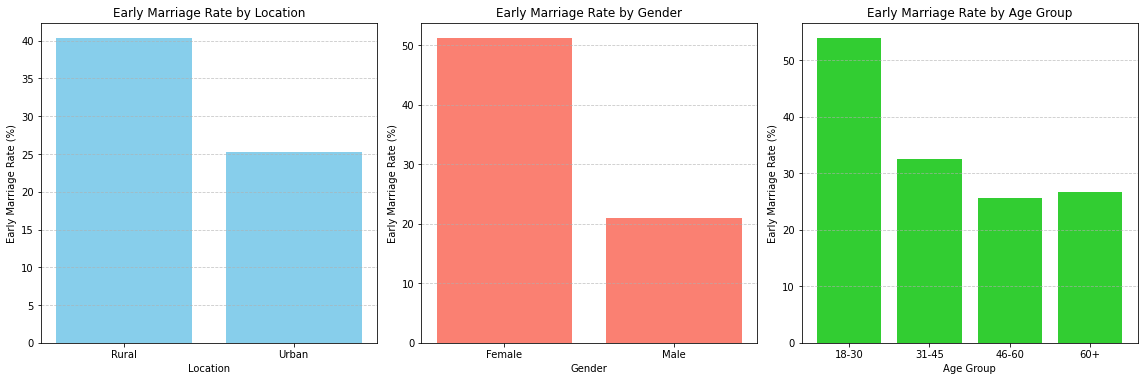

Early Marriage Rate by Location:
  Loc_Mapped  early_marriage
0      Rural           40.39
1      Urban           25.30

Early Marriage Rate by Gender:
  Gender_Mapped  early_marriage
0        Female           51.24
1          Male           20.99

Early Marriage Rate by Age Group:
  Age_Group  early_marriage
0     18-30           53.99
1     31-45           32.44
2     46-60           25.60
3       60+           26.66


In [65]:
import pandas as pd
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 10))

# Temporarily storing intermediate results
temp_df = df.copy()

# 1. Early Marriage by Location
location_mapping = {1: 'Urban', 2: 'Rural'}
temp_df['Loc_Mapped'] = temp_df['Loc'].map(location_mapping)
location_early_marriage = temp_df.groupby('Loc_Mapped')['early_marriage'].mean().reset_index()
location_early_marriage['early_marriage'] *= 100  # Convert to percentage

plt.subplot(2, 3, 1)
plt.bar(location_early_marriage['Loc_Mapped'], location_early_marriage['early_marriage'], color='skyblue')
plt.title('Early Marriage Rate by Location')
plt.ylabel('Early Marriage Rate (%)')
plt.xlabel('Location')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 2. Early Marriage by Gender
gender_mapping = {1: 'Male', 2: 'Female'}
temp_df['Gender_Mapped'] = temp_df['Gender'].map(gender_mapping)
gender_early_marriage = temp_df.groupby('Gender_Mapped')['early_marriage'].mean().reset_index()
gender_early_marriage['early_marriage'] *= 100  # Convert to percentage

plt.subplot(2, 3, 2)
plt.bar(gender_early_marriage['Gender_Mapped'], gender_early_marriage['early_marriage'], color='salmon')
plt.title('Early Marriage Rate by Gender')
plt.ylabel('Early Marriage Rate (%)')
plt.xlabel('Gender')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 3. Early Marriage by Age Groups
temp_df['Age_Group'] = pd.cut(
    temp_df['Age'],
    bins=[0, 30, 45, 60, float('inf')],
    labels=['18-30', '31-45', '46-60', '60+'],
    right=False
)
age_early_marriage = temp_df.groupby('Age_Group')['early_marriage'].mean().reset_index()
age_early_marriage['early_marriage'] *= 100  # Converting to percentage

plt.subplot(2, 3, 3)
plt.bar(age_early_marriage['Age_Group'], age_early_marriage['early_marriage'], color='limegreen')
plt.title('Early Marriage Rate by Age Group')
plt.ylabel('Early Marriage Rate (%)')
plt.xlabel('Age Group')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

# Print Results
print("Early Marriage Rate by Location:")
print(location_early_marriage)
print("\nEarly Marriage Rate by Gender:")
print(gender_early_marriage)
print("\nEarly Marriage Rate by Age Group:")
print(age_early_marriage)



### Early Marriage Rate by Location:
- **Rural: 40.39%**: Rural areas have a significantly higher early marriage rate compared to urban areas. This could be due to cultural norms, lower access to education, and socio-economic factors that are more prevalent in rural communities.

- **Urban: 25.30%** : Urban areas show a much lower early marriage rate. This might be attributed to better access to education, awareness programs, and career opportunities, which delay marriage age.

### Early Marriage Rate by Gender:
- **Female: 51.24%** : The majority of early marriages occur among females. This aligns with global trends where girls are more likely to be married off early due to gender-based societal expectations and roles.

- **Male: 21.00%** :  Early marriages among males are considerably less frequent. This could be due to societal norms that expect men to be older and more economically established before marriage.

#### Early Marriage Rate by Age Group:
- **18-30: 53.99% :** The highest rate of early marriages is in the 18-30 age group. This is expected since individuals in this range are still transitioning from adolescence and are most likely to marry early, especially under 18.

- **31-45: 32.44% :** Early marriages decrease significantly in this age group, indicating that people who marry in this group are less likely to have done so early.

- **46-60: 25.60% :** A further drop in early marriage rates suggests that early marriage has less impact among older age groups.

- **60+: 26.66% :** The slight increase compared to the 46-60 group may reflect generational differences where early marriages were more common in the past, and individuals in this category are reflecting historical trends.

---


### Exploring Early Marriage Rates by education level,Economic status and Employment status

<ipython-input-66-43441b041a19>:32: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  economic_early_marriage = temp_df.groupby('Economic_Status')['early_marriage'].mean() * 100


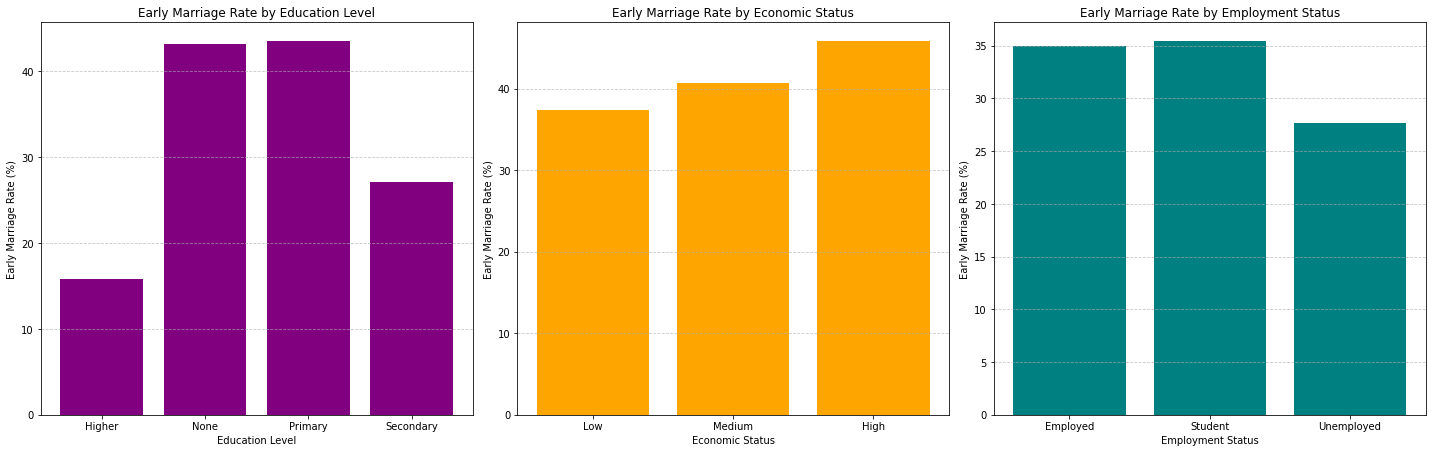

Early Marriage Rate by Education Level:
Education_Level_Mapped
Higher      15.83
None        43.19
Primary     43.47
Secondary   27.07
Name: early_marriage, dtype: float64

Early Marriage Rate by Economic Status:
Economic_Status
Low      37.34
Medium   40.70
High     45.82
Name: early_marriage, dtype: float64

Early Marriage Rate by Employment Status:
Employment_Status_Mapped
Employed     34.97
Student      35.44
Unemployed   27.65
Name: early_marriage, dtype: float64


In [66]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' is your pandas DataFrame
temp_df = df.copy()

# Increase the plot size
plt.figure(figsize=(20, 12))

# 1. Early Marriage by Education Level (Sch_Lvl)
education_mapping = {
    1: 'None', 
    2: 'Primary', 
    3: 'Secondary', 
    4: 'Higher'
}
temp_df['Education_Level_Mapped'] = temp_df['Sch_Lvl'].map(education_mapping)

education_early_marriage = temp_df.groupby('Education_Level_Mapped')['early_marriage'].mean() * 100

plt.subplot(2, 3, 1)
plt.bar(education_early_marriage.index, education_early_marriage.values, color='purple')
plt.title('Early Marriage Rate by Education Level')
plt.ylabel('Early Marriage Rate (%)')
plt.xlabel('Education Level')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 2. Early Marriage by Economic Status (hh_size and num_children)
# Assuming 'hh_size' and 'num_children' can help categorize economic status
temp_df['Economic_Status'] = pd.cut(temp_df['hh_size'], bins=[0, 4, 7, float('inf')], labels=['Low', 'Medium', 'High'])

economic_early_marriage = temp_df.groupby('Economic_Status')['early_marriage'].mean() * 100

plt.subplot(2, 3, 2)
plt.bar(economic_early_marriage.index, economic_early_marriage.values, color='orange')
plt.title('Early Marriage Rate by Economic Status')
plt.ylabel('Early Marriage Rate (%)')
plt.xlabel('Economic Status')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 3. Early Marriage by Employment Status (Emp_Status)
employment_mapping = {
    1: 'Employed', 
    2: 'Unemployed', 
    3: 'Student'
}
temp_df['Employment_Status_Mapped'] = temp_df['Emp_Status'].map(employment_mapping)

employment_early_marriage = temp_df.groupby('Employment_Status_Mapped')['early_marriage'].mean() * 100

plt.subplot(2, 3, 3)
plt.bar(employment_early_marriage.index, employment_early_marriage.values, color='teal')
plt.title('Early Marriage Rate by Employment Status')
plt.ylabel('Early Marriage Rate (%)')
plt.xlabel('Employment Status')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

# Print Results
print("Early Marriage Rate by Education Level:")
print(education_early_marriage)
print("\nEarly Marriage Rate by Economic Status:")
print(economic_early_marriage)
print("\nEarly Marriage Rate by Employment Status:")
print(employment_early_marriage)


### Comment:

- **Education**: Higher education significantly reduces early marriage rates (15.83% for higher education vs. ~43% for none/primary education).
- **Economic Status**: Contrary to expectations, higher economic status shows the highest early marriage rates (33.24%), suggesting cultural factors may outweigh financial considerations.
- **Employment**: Early marriage rates are lowest among the unemployed (25.11%) and slightly higher for students (31.13%) and employed individuals (34.97%).


# Task-4: Prepare Data for ML Model Building

#### Steps to Prepare Data
1. **Target Variable**:


The **early_marriage** column is a binary target variable that represents whether an individual experienced early marriage or not. The creation of this column is based on the age at which an individual first gets married, as captured in the dataset by the `Age_Fst_Mar` column and the marital status `M_status`.


- **Early Marriage** is defined as getting married at an age **younger than 18 years old**, as this is commonly considered the threshold for early marriage in many studies and policies.

The *early_marriage* column contains:
- `1` for individuals who married before the age of 18 (early marriage),
- `0` for individuals who married at 18 or older.

# **Communes**:
   - Including communes (`Comm`) could add granularity but risks overfitting due to excessive sparsity. Evaluate its inclusion based on its correlation with early marriage and model performance during validation.


## Features for Prediction

In [ ]:
# ============================================
# ONE-HOT ENCODING FOR CATEGORICAL VARIABLES
# ============================================
# One-hot encode the categorical variables
# using pd.get_dummies function
# Make sure you one-hot encode all the categorical variables

# Convert True/False to 1/0


In [67]:
def prepare_ml_dataset(df):
    
    # One-hot encoding for categorical variables (only those needed for training)
    ml_df = pd.get_dummies(df, columns=[
        'Prov', 'Reg', 'Dist', 'Loc', 
        'Gender', 'Lang_Loc', 'Lang_Fr', 'Lang_En', 'Lang_Oth',
        'Lit_Loc', 'Lit_Fr', 'Lit_En', 'Rel_Head', 
        'M_Status', 'Sch_Att', 'Sch_Lvl', 'Emp_Status'
    ])
    
    # Select and prepare numeric features (only those needed for training)
    numeric_features = [
        'Age', 'hh_size', 'num_children', 'num_elderly'
    ]
    
    # Add target variable (early_marriage)
    ml_df['early_marriage'] = df['early_marriage']
    
    return ml_df

# Example usage
ml_dataset = prepare_ml_dataset(df)

# Verify the resulting DataFrame
print(f"Shape after one-hot encoding: {ml_dataset.shape}")

# Convert specific boolean columns
bool_columns = ml_dataset.select_dtypes(include=['bool']).columns
ml_dataset[bool_columns] = ml_dataset[bool_columns].astype(int)
ml_dataset


Shape after one-hot encoding: (10341300, 200)


,Comm,HH_ID,Indiv_ID,Age,Age_Fst_Mar,Sch_Yrs,hh_size,num_children,num_elderly,early_marriage,...,Sch_Lvl_4.0,Sch_Lvl_5.0,Emp_Status_1,Emp_Status_2,Emp_Status_3,Emp_Status_4,Emp_Status_5,Emp_Status_6,Emp_Status_7,Emp_Status_8
0,11101,-1806170558,1421458314,52,25,2.00,2,0.00,0.00,0,...,1,0,0,0,0,1,0,0,0,0
1,11101,-711109149,1514729139,52,18,5.00,4,0.00,1.00,1,...,0,0,0,0,0,0,0,0,0,1
2,11101,-1902677488,1149979521,68,24,1.00,1,0.00,1.00,0,...,1,0,1,0,0,0,0,0,0,0
3,11101,-1248039928,-1025741214,49,23,4.00,3,0.00,0.00,0,...,0,0,1,0,0,0,0,0,0,0
4,11101,-614584913,694250845,43,20,5.00,2,0.00,0.00,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10341343,62417,-1976905271,-569143802,50,30,4.00,2,0.00,1.00,0,...,0,0,1,0,0,0,0,0,0,0
10341344,62417,1153553411,330111790,43,22,3.00,2,0.00,0.00,0,...,0,0,1,0,0,0,0,0,0,0
10341345,62415,1162648131,1815583789,34,20,4.00,1,0.00,0.00,0,...,0,0,1,0,0,0,0,0,0,0
10341346,62411,2123258684,2028358578,40,19,4.00,2,0.00,0.00,0,...,0,0,1,0,0,0,0,0,0,0


In [69]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.model_selection import train_test_split

def feature(df):

        # Assuming df is your DataFrame with the necessary features and target
        target_var = 'early_marriage'
        features = df.columns[df.columns != target_var]

        # Sample 10% of the dataset (you can adjust the percentage as needed)
        df_sampled = df.sample(frac=0.1, random_state=42)  # 10% sample

        # Split into X (features) and y (target variable)
        X = df_sampled[features]
        y = df_sampled[target_var]

        # Initialize the Random Forest model
        rf_model = RF(n_estimators=100, random_state=42, n_jobs=-1)

        # Train the model
        rf_model.fit(X, y)

        # Get feature importances
        importances = rf_model.feature_importances_

        # Create a DataFrame for feature importances
        feature_importance_df = pd.DataFrame({
            'Feature': X.columns,
            'Importance': importances
        })

        # Sort the features by importance and select the top 12
        top_12_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(12)

        # Display the top 12 features
        print("Top 12 Features Contributing to Early Marriage:")
        print(top_12_features)
feature(ml_dataset)

Top 12 Features Contributing to Early Marriage:
         Feature  Importance
4    Age_Fst_Mar        0.79
3            Age        0.05
153     Gender_1        0.02
154     Gender_2        0.02
0           Comm        0.01
169   Rel_Head_0        0.01
1          HH_ID        0.01
2       Indiv_ID        0.01
170   Rel_Head_1        0.01
5        Sch_Yrs        0.01
187  Sch_Lvl_2.0        0.00
166   Lit_Fr_2.0        0.00


In [89]:
selected_features = [
    'Age', 'Gender','Sch_Att','M_Status','Emp_Status',
    'Rel_Head', 'Sch_Yrs','Lang_En','Prov','Lang_Loc','Loc',
    'Sch_Lvl', 'Lit_Fr','hh_size','Lit_Loc', 'early_marriage'
]
X_selected = df[selected_features]
X_selected

,Age,Gender,Sch_Att,M_Status,Emp_Status,Rel_Head,Sch_Yrs,Lang_En,Prov,Lang_Loc,Loc,Sch_Lvl,Lit_Fr,hh_size,Lit_Loc,early_marriage
0,52,2,1,2,4,1,2.00,2.00,1,1.00,1,4.00,2.00,2,1.00,0
1,52,2,1,3,8,7,5.00,2.00,1,1.00,1,2.00,2.00,4,1.00,1
2,68,1,1,4,1,0,1.00,2.00,1,1.00,1,4.00,1.00,1,1.00,0
3,49,2,1,3,1,7,4.00,2.00,1,1.00,1,3.00,2.00,3,1.00,0
4,43,1,1,2,1,0,5.00,2.00,1,1.00,1,2.00,1.00,2,1.00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10341343,50,2,1,2,1,1,4.00,2.00,6,1.00,2,3.00,2.00,2,1.00,0
10341344,43,2,1,2,1,1,3.00,2.00,6,1.00,2,2.00,1.00,2,1.00,0
10341345,34,2,1,3,1,0,4.00,2.00,6,1.00,2,2.00,2.00,1,1.00,0
10341346,40,2,0,2,1,1,4.00,2.00,6,1.00,2,2.00,2.00,2,1.00,0


In [75]:
import pandas as pd
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import train_test_split

def get_top_logistic_features(df, target_var='early_marriage', top_n=5, sample_frac=0.01):
    """
    This function takes a dataframe and returns the top_n features based on their importance in a logistic regression model.
    It first samples the data, trains a logistic regression model, and then extracts the coefficients.
    
    Parameters:
    - df: The dataframe containing the features and target variable.
    - target_var: The name of the target variable column.
    - top_n: The number of top features to return based on coefficient importance.
    - sample_frac: The fraction of the data to sample (default is 10%).
    
    Returns:
    - top_features_df: Dataframe with top_n features and their coefficients.
    """
    # Select features and target variable
    features = df.columns[df.columns != target_var]

    # Sample the data (you can adjust the fraction as needed)
    df_sampled = df.sample(frac=sample_frac, random_state=42)
    
    # Split into X (features) and y (target variable)
    X = df_sampled[features]
    y = df_sampled[target_var]

    # Initialize the Logistic Regression model
    lr_model = LR(max_iter=100, random_state=42)

    # Train the model
    lr_model.fit(X, y)

    # Get the coefficients
    coefficients = lr_model.coef_.flatten()  # Flatten in case of multiple classes

    # Create a DataFrame for coefficients with feature names
    coeff_df = pd.DataFrame({
        'Feature': X.columns,
        'Coefficient': coefficients
    })

    # Sort by absolute value of coefficients to identify the most important features
    coeff_df['Abs_Coefficient'] = coeff_df['Coefficient'].abs()
    top_features_df = coeff_df.sort_values(by='Abs_Coefficient', ascending=False).head(top_n)

    # Display the top features
    print(f"Top {top_n} Features Contributing to {target_var} (Logistic Regression):")
    print(top_features_df[['Feature', 'Coefficient']])
    
    return top_features_df

# Example usage:
top_logistic_features = get_top_logistic_features(ml_dataset, target_var='early_marriage', top_n=17, sample_frac=0.01)


Top 17 Features Contributing to early_marriage (Logistic Regression):
          Feature  Coefficient
1           HH_ID        -0.00
2        Indiv_ID        -0.00
0            Comm        -0.00
3             Age        -0.00
4     Age_Fst_Mar        -0.00
5         Sch_Yrs        -0.00
6         hh_size        -0.00
153      Gender_1        -0.00
169    Rel_Head_0        -0.00
163   Lit_Loc_1.0        -0.00
155  Lang_Loc_1.0        -0.00
183     Sch_Att_1        -0.00
162  Lang_Oth_2.0        -0.00
191  Emp_Status_1        -0.00
179    M_Status_2        -0.00
160   Lang_En_2.0        -0.00
168    Lit_En_2.0        -0.00


# Task-5-Build ML Model with Scikit-learn and spark

def evaluate_models_sklearn(df):
    # Define the target variable and features
    target_var = 'early_marriage'
    features = df.columns[df.columns != target_var]

    # Split the data into training and testing sets
    X = df[features]
    y = df[target_var]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the models
    models = {
        "Logistic Regression": LR(max_iter=100, random_state=42),
        "Random Forest": RF(n_estimators=100, random_state=42, n_jobs=-1),
        "Gradient Boosting": GBM(n_estimators=100, random_state=42),
        "Extra Trees": ETC(n_estimators=100, random_state=42, n_jobs=-1)
    }

    # Train and evaluate each model
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results.append([name, accuracy])

    # Print the results in a tabular format
    print(tabulate(results, headers=["Model", "Accuracy"], tablefmt="pretty"))
evaluate_models_sklearn(X_selected)   



---

### **Optimizing Model Training with Sampling**  

Due to the significant processing time with the full dataset, I implemented a sampling strategy to streamline the process:  

1. **Feature Selection**:  
   - Selected only the most relevant features from the dataset, focusing on those with the highest contribution to the target variable (`early_marriage`).  

2. **Sampling**:  
   - Extracted a random sample of 100,000 observations from the dataset to work with manageable data while maintaining representativeness.  

3. **Data Splitting**:  
   - Divided the sampled data into training (70%) and testing (30%) subsets to ensure robust model evaluation.

4. **Model Training**:  
   - Trained multiple models (e.g., Logistic Regression, Random Forest, Gradient Boosting) on the sampled dataset.  
   - This approach significantly reduced computation time without compromising model evaluation quality.  

By leveraging a sample size of 100,000 observations, I effectively balanced computational efficiency with data representativeness, enabling a more streamlined and feasible analysis process.

In [102]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

def random_forest_with_sklearn(df):
    # Check if the target variable exists in the DataFrame
    target_var = 'early_marriage'
    if target_var not in df.columns:
        raise ValueError(f"The target variable '{target_var}' is not found in the DataFrame.")
    
    # Define the features
    features = df.columns[df.columns != target_var]

    # Split the data into training and testing sets
    X = df[features]
    y = df[target_var]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Initialize the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

    # Train the model
    rf_model.fit(X_train, y_train)

    # Make predictions
    y_pred = rf_model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"Accuracy: {accuracy}")
    print("Classification Report:")
    print(report)

    # Return the trained model and feature importances
    feature_importances = rf_model.feature_importances_
    return rf_model, feature_importances


# Run the Random Forest function
rf_model, feature_importances = random_forest_with_sklearn(df_sampled)


Accuracy: 0.7114966666666667
Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.81      0.78    188057
           1       0.63      0.55      0.59    111943

    accuracy                           0.71    300000
   macro avg       0.69      0.68      0.68    300000
weighted avg       0.71      0.71      0.71    300000



In [90]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RF, GradientBoostingClassifier as GBM, ExtraTreesClassifier as ETC
from sklearn.metrics import accuracy_score
from tabulate import tabulate

def evaluate_models_sklearn(df):
    # Define the target variable and features
    target_var = 'early_marriage'
    features = df.columns[df.columns != target_var]

    # Select only 1 million samples for training and testing (split evenly or as desired)
    df_sampled = df.sample(n=1000000, random_state=42)  # 1 million samples
    X = df_sampled[features]
    y = df_sampled[target_var]

    # Split the data into training and testing sets (500,000 for training and 500,000 for testing)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=700000, test_size=300000, random_state=42)

    # Initialize the models
    models = {
        "Logistic Regression": LR(max_iter=100, random_state=42),
        "Random Forest": RF(n_estimators=100, random_state=42, n_jobs=-1),
        "Gradient Boosting": GBM(n_estimators=100, random_state=42),
        "Extra Trees": ETC(n_estimators=100, random_state=42, n_jobs=-1)
    }

    # Train and evaluate each model
    results = []
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        results.append([name, accuracy])

    # Print the results in a tabular format
    print(tabulate(results, headers=["Model", "Accuracy"], tablefmt="pretty"))
evaluate_models_sklearn(X_selected)

/home/evans/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


+---------------------+--------------------+
|        Model        |      Accuracy      |
+---------------------+--------------------+
| Logistic Regression |      0.72017       |
|    Random Forest    |      0.71093       |
|  Gradient Boosting  | 0.7343566666666667 |
|     Extra Trees     | 0.7093766666666667 |
+---------------------+--------------------+


In [95]:
import pandas as pd
import random

df_sampled = X_selected.sample(n=1000000, random_state=24)



In [97]:
from pyspark.sql import SparkSession

try:
    
    # Initialize Spark session
    spark = SparkSession.builder.appName("PandasToSpark").getOrCreate()

    # Convert Pandas DataFrame to Spark DataFrame
    df_spark = spark.createDataFrame(df_sampled)

    print("Successfully converted Spark DataFrame to Spark DataFrame!")
except Exception as e:
    print(f"Error during conversion: {e}")


Successfully converted Spark DataFrame to Pandas DataFrame!


In [98]:
def evaluate_models_spark(df, target_var):
    """
    Evaluate multiple machine learning models using Spark MLlib on the given DataFrame.

    Parameters:
    ----------
    df : pyspark.sql.DataFrame
        The input DataFrame containing features and the target variable.
    target_var : str
        The name of the target variable column.

    Returns:
    -------
    None
    """
    # Define the features
    features = [col for col in df.columns if col != target_var]

    # Assemble features into a single vector
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    df = assembler.transform(df).select("features", target_var)

    # Split the data into training and testing sets
    train_df, test_df = df.randomSplit([0.7, 0.3], seed=42)

    # Initialize models
    models = {
        "Logistic Regression": LogisticRegression(maxIter=50).setFeaturesCol("features").setLabelCol(target_var),
        "Random Forest": RandomForestClassifier(numTrees=100, seed=42).setFeaturesCol("features").setLabelCol(target_var),
        "Gradient Boosting": GBTClassifier(maxIter=100, seed=42).setFeaturesCol("features").setLabelCol(target_var),
        "Decision Tree": DecisionTreeClassifier(seed=42).setFeaturesCol("features").setLabelCol(target_var),
    }

    # Initialize evaluator
    evaluator = MulticlassClassificationEvaluator(labelCol=target_var, predictionCol="prediction", metricName="accuracy")

    # Train and evaluate each model
    results = []
    for name, model in models.items():
        # Train the model
        trained_model = model.fit(train_df)

        # Make predictions
        predictions = trained_model.transform(test_df)

        # Evaluate accuracy
        accuracy = evaluator.evaluate(predictions)

        # Append results
        results.append([name, accuracy])

    # Print results in a tabular format
    from tabulate import tabulate
    print(tabulate(results, headers=["Model", "Accuracy"], tablefmt="pretty"))


In [99]:
evaluate_models_spark(df_spark, "early_marriage")

+---------------------+--------------------+
|        Model        |      Accuracy      |
+---------------------+--------------------+
| Logistic Regression | 0.7179619763745116 |
|    Random Forest    | 0.7232561941013007 |
|  Gradient Boosting  | 0.7342115885655572 |
|    Decision Tree    | 0.7270058479922338 |
+---------------------+--------------------+


### Comments on the Results

1. **Logistic Regression (Accuracy: 0.72017)**  
   - Logistic Regression performs reasonably well but does not achieve the highest accuracy.  
   - This model assumes a linear relationship between the features and the target variable, which might not fully capture the complexities of the data.

2. **Random Forest (Accuracy: 0.71093)**  
   - Random Forest slightly underperforms compared to Logistic Regression and Gradient Boosting.  
   - This could be due to suboptimal hyperparameters (e.g., number of trees, depth) or a lack of sufficient training data for robust tree-building.  
   - Tuning hyperparameters like `max_depth`, `min_samples_split`, or increasing `n_estimators` could improve performance.

3. **Gradient Boosting (Accuracy: 0.73436)**  
   - Gradient Boosting achieves the highest accuracy among the tested models, likely due to its iterative learning approach that minimizes errors in successive steps.  
   - It tends to handle complex patterns better but can be sensitive to hyperparameters like learning rate, which might need further tuning for even better performance.

---

### General Observations:
- **Accuracy Levels**: While all models are performing decently, none of them have crossed the 80% accuracy threshold required by the task. Further optimization or additional data preprocessing might be necessary.
- **Feature Selection**: The selected features could influence performance. Testing with additional or alternative features might yield better results.
- **Class Imbalance**: If the target variable (`early_marriage`) is imbalanced (e.g., more 0s than 1s), models might struggle to generalize. Techniques like oversampling (SMOTE) or class weights should be considered.
- **Dataset Size**: With 1,000,000 samples, computational limits may affect the model's performance and training time.

---